In [1]:
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import sys
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from PDE2D import GreenSampling
import matplotlib.patches as patches

In [2]:
green = GreenSampling.Polynomial

In [3]:

normalization = True
resolution = 128
spp = 2 ** 22
conf_number = 0
fd_step = 5e-3
e_shell = 1e-5
computation_radius = 0.95
on_boundary = False
parameters = {}
parameters["freq"] = 1
parameters["bias"] = -4
parameters["scale"] = -4
res_sdf = 64

num_electrodes = 16
is_delta = False
electrode_length = 0.1
injection_confs=[[0,10], [0,5]]
conf_numbers = [UInt32(0), UInt32(1)]
conf_vis = 0

out_boundary_el = CircleWithElectrodes(radius = 1.0, num_electrodes=num_electrodes, is_delta = False, 
                                          electrode_length=electrode_length, injection_confs=injection_confs,centered = True)

out_boundary_delta = CircleWithElectrodes(radius = 1.0, num_electrodes=num_electrodes, is_delta = True, 
                                         electrode_length=electrode_length, injection_confs=injection_confs,centered = True)

out_neumann = out_boundary_el.create_neumann_function(conf_numbers)
out_boundary_naive = CircleShape(origin =Point2f(0.0, 0.0), radius = 1.0, name = "out-boundary", 
                                 neumann = out_neumann, dirichlet_map = np.array([False]), epsilon = e_shell)


origin_object = np.array([0.2, 0.1])
radius_object = 0.2
object_potential = [[0]]

in_boundary = CircleShape(origin =Point2f(origin_object), radius = radius_object, name = "in-boundary", epsilon=e_shell)

in_boundaries = [in_boundary]

α = ConstantCoefficient("diffusion", 1)
shape_el = BoundaryWithDirichlets(out_boundary_el, in_boundaries, dirichlet_values = object_potential)
shape_delta = BoundaryWithDirichlets(out_boundary_delta, in_boundaries, dirichlet_values = object_potential)
shape_naive = BoundaryWithDirichlets(out_boundary_naive, in_boundaries, dirichlet_values = object_potential)
data_holder_el = DataHolder(shape_el, α  = α)
data_holder_delta = DataHolder(shape_delta, α = α)
data_holder_naive = DataHolder(shape_naive, α = α)

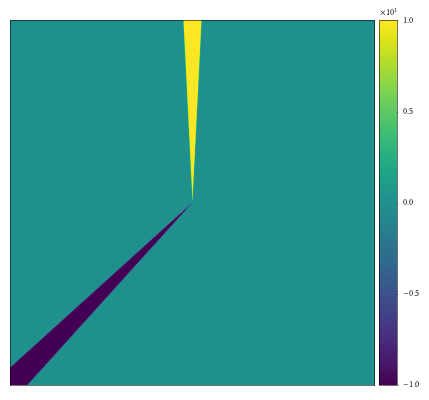

In [4]:
bbox = [[-1.1,-1.1],[1.1,1.1]]
resolution_image = [256, 256]
spp_image = 256
fig, ax = plt.subplots(1,1, figsize = (5,5))
out_neumann[conf_vis].visualize(ax, bbox);

In [5]:

points = create_image_points(bbox, resolution_image, spp_image)
wos_naive = WostConstant(data_holder_naive, green_sampling=green)
wos_delta = WostConstant(data_holder_delta, green_sampling=green)
wos_el = WostConstant(data_holder_el, green_sampling = green)

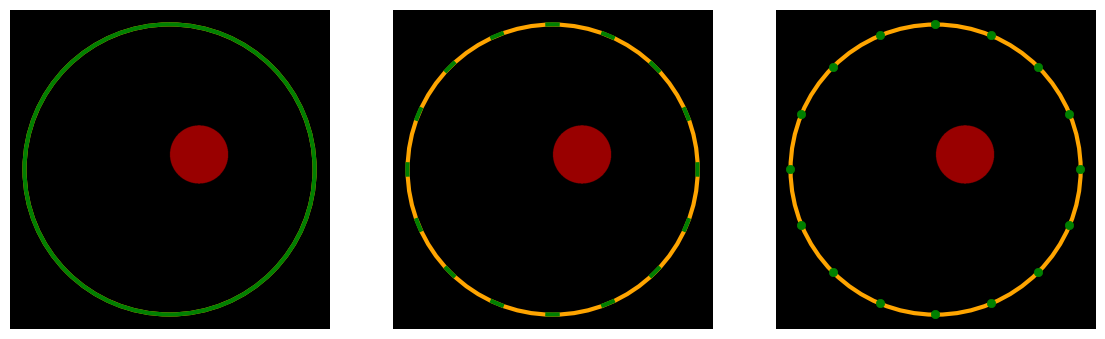

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 5])
shape_naive.sketch_image(ax1, bbox, resolution = [1024,1024]);
shape_el.sketch_image(ax2, bbox, resolution = [1024, 1024]);
shape_delta.sketch_image(ax3, bbox, resolution = [1024, 1024]);

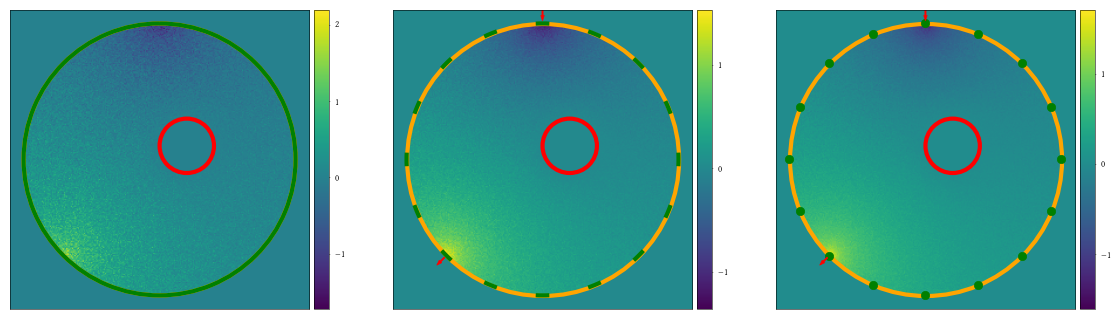

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 5])
L_naive, _ = wos_naive.solve(points_in = points, conf_numbers = conf_numbers)
L_el, _ = wos_el.solve(points_in = points, conf_numbers = conf_numbers)
L_delta, _ = wos_delta.solve(points_in = points, conf_numbers = conf_numbers)
image_naive, tensor = create_image_from_result(L_naive, resolution_image)
image_el, tensor = create_image_from_result(L_el, resolution_image)
image_delta, tensor = create_image_from_result(L_delta, resolution_image)

plot_image(image_naive[conf_vis], ax1)
plot_image(image_el[conf_vis], ax2)
plot_image(image_delta[conf_vis], ax3)
shape_naive.sketch(ax1, bbox, resolution_image)
shape_el.sketch(ax2, bbox, resolution_image)
shape_el.out_boundary.sketch_electrode_input(ax2, bbox, resolution_image, conf_number = conf_vis)
shape_delta.sketch(ax3, bbox, resolution_image)
shape_delta.out_boundary.sketch_electrode_input(ax3, bbox, resolution_image, conf_number = conf_vis)

In [8]:
print(data_holder_naive.NEE)
print(data_holder_el.NEE)
print(data_holder_delta.NEE)

NEE.Normal
NEE.Special
NEE.Special


Mean:
0.000654304
Variance:
0.011859333


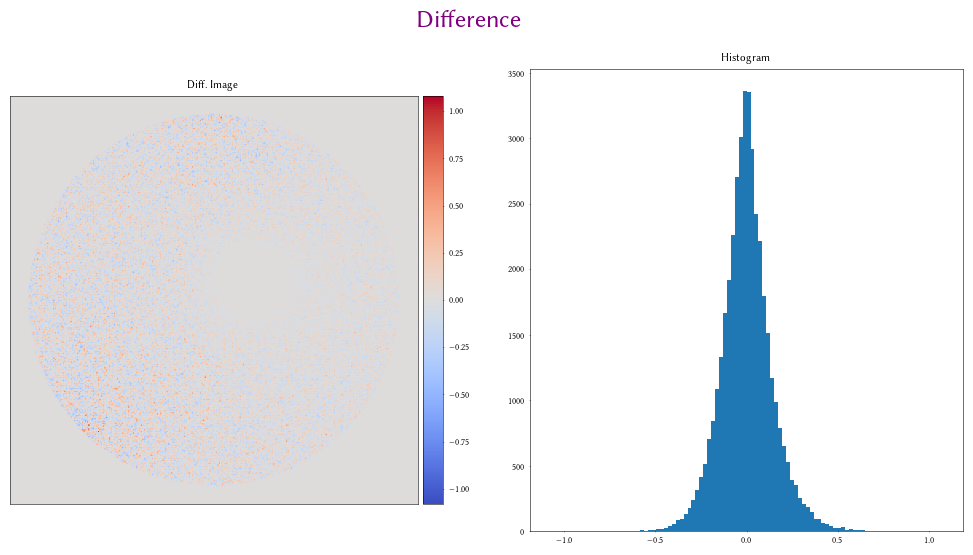

In [9]:
sketch_diff(image_naive[conf_vis], image_el[conf_vis], max_range = 10)

Mean:
-5.537294e-05
Variance:
0.0017367627


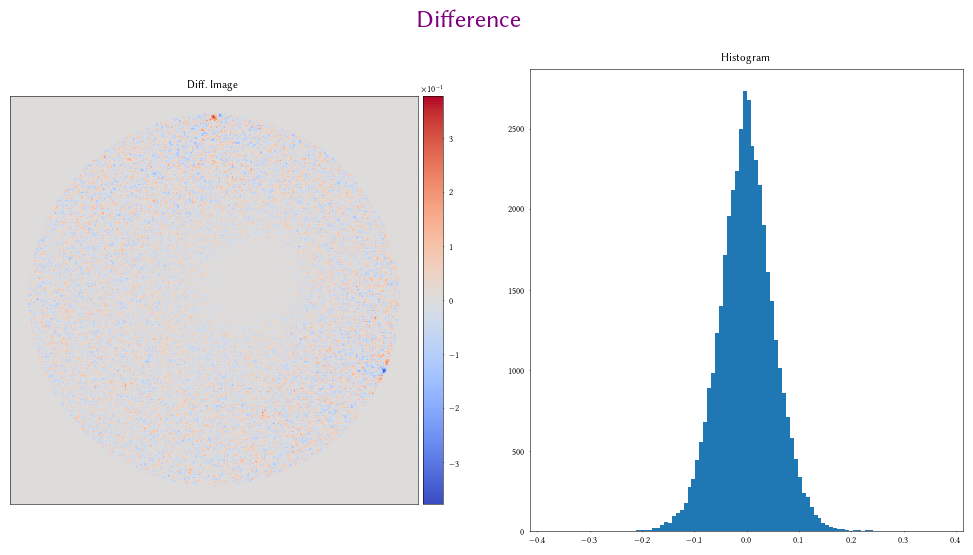

In [10]:
sketch_diff(image_el[1], image_delta[1], max_range = 10)

In [11]:
spe = 2 ** 22
points_el_naive, active_conf_naive, electrode_nums_naive = wos_el.input.shape.out_boundary.create_electrode_points(spe = spe, conf_numbers = [UInt32(0)])
points_el, active_conf, electrode_nums = wos_el.input.shape.out_boundary.create_electrode_points(spe = spe, conf_numbers = [UInt32(0), UInt32(1)])

L_naive, _ = wos_naive.solve(points_in = points_el, active_conf_in = active_conf, conf_numbers = [UInt32(0), UInt32(1)], all_inside = True)
L_el, _ = wos_el.solve(points_in = points_el, active_conf_in = active_conf, conf_numbers = [UInt32(0), UInt32(1)], all_inside = True)
L_delta, _ = wos_delta.solve(points_in = points_el, active_conf_in = active_conf, conf_numbers = [UInt32(0), UInt32(1)], all_inside = True)

normalization = True
el_naive = create_electrode_result(L_naive, spe, electrode_nums[0], apply_normalization = normalization)
el_el = create_electrode_result(L_el, spe, electrode_nums, apply_normalization = normalization)
el_delta = create_electrode_result(L_delta, spe, electrode_nums, apply_normalization = normalization)


Text(0.5, 1.0, 'spe = 2 ** 22')

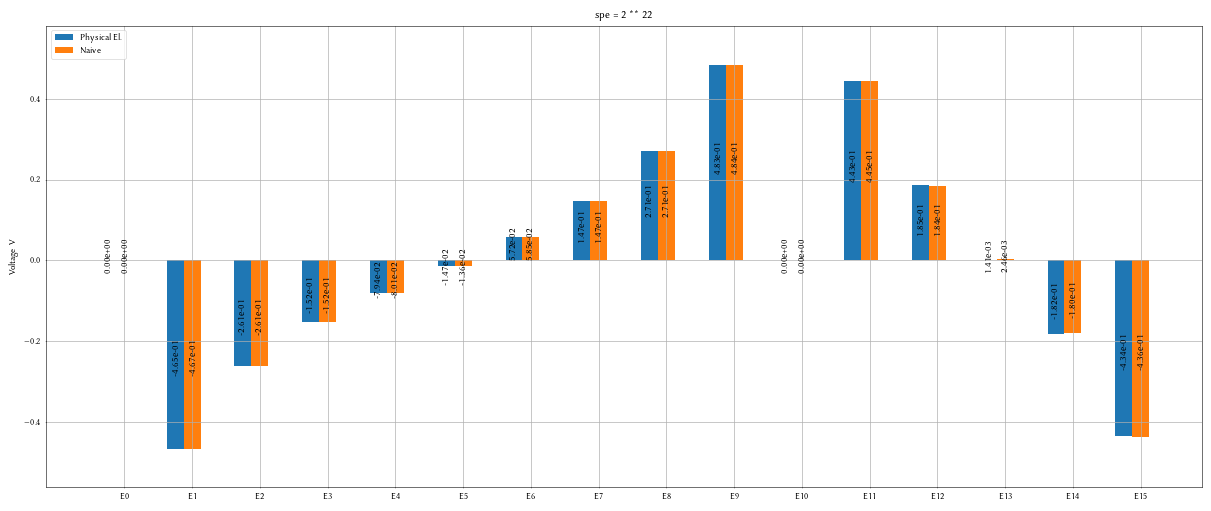

In [12]:
fig, ax = plt.subplots(layout='constrained', figsize = (12,5))
plot_primals(ax, el_naive[0], el_el[0], electrode_nums, num_electrodes, name1 = "Naive", name2 = "Physical El.")
ax.set_title(f"spe = 2 ** {dr.log2i(spe)}")

Text(0.5, 1.0, 'spe = 2 ** 22')

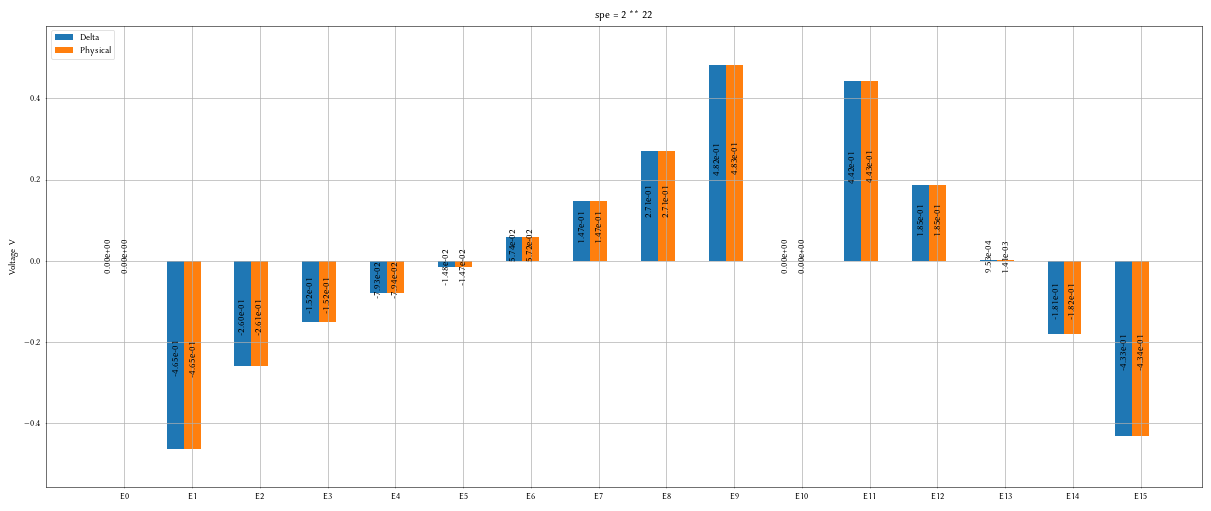

In [13]:
fig, ax = plt.subplots(layout='constrained', figsize = (12,5))
plot_primals(ax, el_el[0], el_delta[0], electrode_nums, num_electrodes, name1 = "Physical", name2 = "Delta")
ax.set_title(f"spe = 2 ** {dr.log2i(spe)}")

Text(0.5, 1.0, 'spe = 2 ** 22')

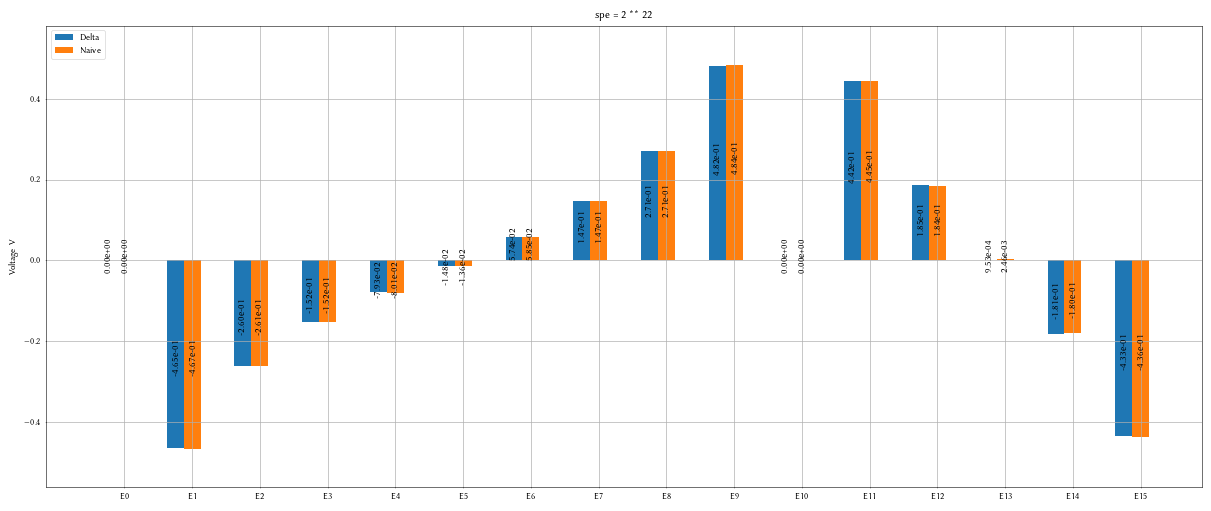

In [14]:
fig, ax = plt.subplots(layout='constrained', figsize = (12,5))
plot_primals(ax, el_naive[0], el_delta[0], electrode_nums, num_electrodes, name1 = "Naive", name2 = "Delta")
ax.set_title(f"spe = 2 ** {dr.log2i(spe)}")